# CDS Insights Challenge

#### By Eric Osband eo255

Challenge:

Applications of single-cell RNA sequencing in various biomedical research areas have been blooming. This technology provides unprecedented opportunities to study disease heterogeneity at the cellular level. However, unique characteristics of scRNA-seq data, including large dimensionality, high dropout rates, and possibly batch effects, bring difficulty into the analysis of such data.

Astrocytoma is the most common and malignant type of primary brain tumor affecting adults and can occur in most parts of the brain and in the spinal cord (de Sousa, 2017). One example of astrocytoma scRNA-seq-data was generated by Venteicher et al. (2017) and available in the Gene Expression Omnibus database under accession number GSE89567 (https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE89567). 

We would like you to programatically explore this dataset and find some interesting insights about it. We suggest taking the time to clean and explore the data, and then diving deeper using more advanced techniques if you know them. Such techniques include, but are not limited to, clustering, modelling, dimensionality reduction, feature engineering, etc. Be creative and have fun!


# Import Statements <a id = "import">

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d # needed for 3d plotting
import pandas as pd
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.decomposition import PCA
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.cluster import DBSCAN
import seaborn as sns
from statistics import mean
from itertools import combinations
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier


%matplotlib inline
#plt.style("")

# Load Data <a id = "load">

In [2]:
df_allcols = pd.read_csv("./data.txt",sep='\t', nrows = 10000)
df_allcols.head()

,Unnamed: 0,MGH42_P7_A01,MGH42_P7_A02,MGH42_P7_A03,MGH42_P7_A04,MGH42_P7_A05,MGH42_P7_A07,MGH42_P7_A09,MGH42_P7_A11,MGH42_P7_A12,...,MGH107neg_P2_E06,MGH107pos_P2_B03,MGH107neg_P1_F03,MGH107neg_P1_G06,MGH107neg_P2_H03,MGH107neg_P2_C05,MGH107pos_P2_D07,MGH107neg_P1_E01,MGH107pos_P2_G09,MGH107neg_P1_D06
0,'A1BG',1.1928,0.000000,0.00000,0.0000,0.0000,0.66903,0.00000,0.0000,0.0000,...,0.0,0.0000,0.0,0.0,0.0,0.00000,0.0000,2.4772,0.0000,0.0
1,'A1BG-AS1',0.0000,0.000000,0.00000,0.0000,0.0000,0.00000,0.00000,0.0000,0.0000,...,0.0,0.0000,0.0,0.0,0.0,0.83996,0.0000,0.0000,0.0000,0.0
2,'A1CF',0.0000,0.094912,0.00000,0.0000,0.0000,0.00000,0.00000,0.0000,0.0000,...,0.0,0.0000,0.0,0.0,0.0,0.00000,0.0000,0.0000,0.0000,0.0
3,'A2M',7.0439,7.609500,0.77062,7.6146,0.0000,0.00000,0.27501,8.1624,6.5655,...,0.0,8.6046,0.0,0.0,0.0,0.00000,9.5281,0.0000,6.8999,0.0
4,'A2M-AS1',0.0000,0.000000,0.00000,0.0000,2.0339,2.39420,0.00000,0.0000,0.0000,...,0.0,0.0000,0.0,0.0,0.0,0.00000,0.0000,0.0000,0.0000,0.0


After a couple hours of researching, I have understood this (quite strange) dataset as the following:

1) What is represented by rows are expression levels of individual genes in each of the columns, the names of which seen in column 0. The total number of rows, and thus number of genes measured, was 23686 (above you can see that I only included the top 5000 of those to keep memory size down).

2) Each of the columns corresponds to a different astrocytoma cell in which the genes (rows) were measured. Now, the columns are not independent of each other. The first 5-6 characters of the column name (everything before the first underscore) is of the form "MGH$n$", where $n \in \{1,2,\ldots,10\}$, represents which of the 10 tumors the cell was taken from.

So the question is, *what to do now?* There is no "target" column that we're clearly trying to predict from this dataset. Additionally, it is very important to note that **neither the columns nor the rows are independent.** In a "traditional dataset", the rows represent (mostly) independent and identically distributed samples from a single larger dataset. So the trouble here is to find an axis along which the data is independent. I will try out a couple things.

In [3]:
import re

In [4]:
cols = df_allcols.columns[1:]
allcols = cols
# print(cols[-100:])
nums = list(set(re.findall("[MGH|mgh]*([0-9]+).*","\n".join(cols))))
print("The separated list of numbers is:",nums)
print("Length of this list (should be 10 because we were told 10 tumors sampled):", len(nums))

The separated list of numbers is: ['42', '57', '107', '64', '45', '103', '56', '61', '44', '43']
Length of this list (should be 10 because we were told 10 tumors sampled): 10


In [5]:
df_allcols.describe()

,MGH42_P7_A01,MGH42_P7_A02,MGH42_P7_A03,MGH42_P7_A04,MGH42_P7_A05,MGH42_P7_A07,MGH42_P7_A09,MGH42_P7_A11,MGH42_P7_A12,MGH42_P7_B02,...,MGH107neg_P2_E06,MGH107pos_P2_B03,MGH107neg_P1_F03,MGH107neg_P1_G06,MGH107neg_P2_H03,MGH107neg_P2_C05,MGH107pos_P2_D07,MGH107neg_P1_E01,MGH107pos_P2_G09,MGH107neg_P1_D06
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,...,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,0.583465,0.560454,0.813069,0.620897,0.761298,0.800472,0.703074,0.585490,0.513311,0.547015,...,0.634640,0.459217,0.653544,0.608200,0.519441,0.656897,0.383834,0.628975,0.377932,0.576965
std,1.355298,1.402599,1.490211,1.423594,1.548118,1.520754,1.424268,1.412203,1.313251,1.379229,...,1.504584,1.392228,1.506943,1.473331,1.410101,1.502822,1.302929,1.450548,1.287287,1.455620
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.195665,0.000000,0.837135,0.214432,0.483360,0.713260,0.447840,0.117700,0.109690,0.000000,...,0.000000,0.000000,0.116360,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,10.946000,11.594000,9.774500,10.702000,9.075000,9.320700,8.949100,11.250000,12.039000,11.974000,...,9.437000,10.510000,10.066000,9.744800,10.296000,9.962100,10.031000,9.701200,10.631000,9.724300


Description of the dataset: tab-delimited text file containing the normalized expression levels (E) for 23,686 analyzed genes (rows, first, column indicates Gene Symbols) across 6341 astrocytoma cells (columns, sample names indicated at the top row( that passed QC from 10 tumors.

In [6]:
genes = (df_allcols.iloc[:,0])
def get_color(genes):
    """
    Color picker function that returns an integer corresponding to the first two characters in the gene name
    """
    x = []
    for gene in genes:
         x.append((ord(gene[1]) - ord('A')) * 9 + ord(gene[2]))
    return x

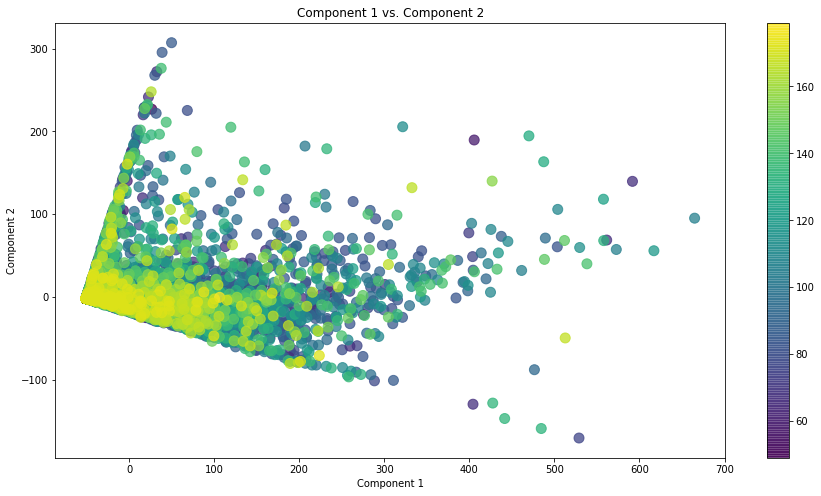

In [7]:
# PCAs
df = df_allcols[allcols]
pca = PCA(n_components = 2)
x_pca = pca.fit(df).transform(df)
plt.figure(figsize = (15,8))
plt.scatter(x_pca[:,0],x_pca[:,1], c = get_color(genes), s = 100, alpha = 0.75, marker = "o",)
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.title("Component 1 vs. Component 2")
plt.colorbar()
plt.show()

# Now x_pca is a two-dimensional list of the two axes along the data with the most variance

Well, this is not what we want to see.

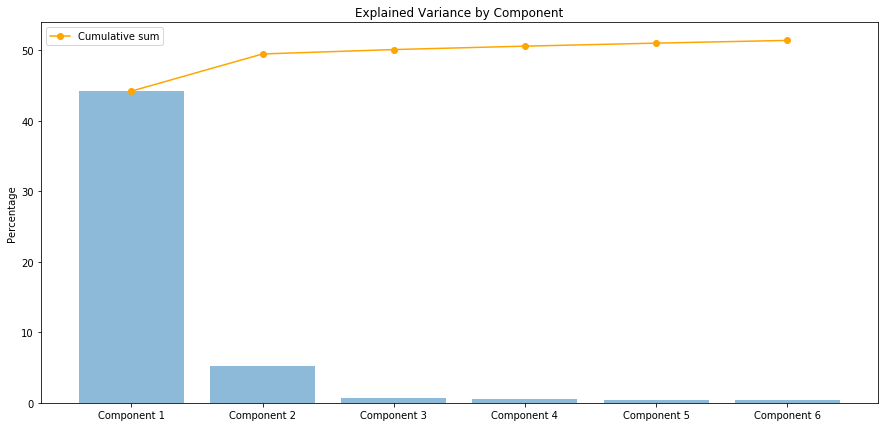

In [8]:
numComponents = 6
pca = PCA(n_components = numComponents).fit(df)

plt.figure(figsize=(15,7))
objects = ["Component " + str(i+1) for i in range(numComponents)]
y_pos = np.arange(len(objects))
performance = pca.explained_variance_ratio_ * 100
cumsum = np.cumsum(performance)

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.title("Explained Variance by Component")
plt.ylabel("Percentage")
plt.plot(y_pos,cumsum, linestyle='-', marker='o', c = "orange", label="Cumulative sum")
plt.legend(loc="best")
plt.show()

As you can see, this PCA analsis that we see above demonstrates that nearly all of the variance in the dataset is caused by the very first PCA component. This is both good and bad for us. Bad because what we saw above is the best graph we're going to see of the data. But potentially good because if we remove those first two components, from our dataset, our data will be much more condensed. 

# Transposed:

In [9]:
dft = df_allcols[df_allcols.columns[1:]].transpose()
df = dft
df.head()

,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
MGH42_P7_A01,1.1928,0.0,0.000000,7.04390,0.0000,0.00000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00000,0.00000,0.0,0.0,0.6248,0.0
MGH42_P7_A02,0.0000,0.0,0.094912,7.60950,0.0000,0.00000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.38957,0.00000,0.0,0.0,5.2269,0.0
MGH42_P7_A03,0.0000,0.0,0.000000,0.77062,0.0000,0.19535,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.34596,0.28688,0.0,0.0,3.3357,0.0
MGH42_P7_A04,0.0000,0.0,0.000000,7.61460,0.0000,0.32077,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00000,0.00000,0.0,0.0,3.9095,0.0
MGH42_P7_A05,0.0000,0.0,0.000000,0.00000,2.0339,0.20664,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00000,0.00000,0.0,0.0,3.6827,0.0


In [10]:
df.describe()

,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
count,6341.000000,6341.000000,6341.000000,6341.000000,6341.000000,6341.000000,6341.000000,6341.000000,6341.000000,6341.0,...,6341.000000,6341.000000,6341.000000,6341.000000,6341.000000,6341.000000,6341.000000,6341.00000,6341.000000,6341.000000
mean,0.194519,0.249201,0.016097,1.359722,0.101350,0.093437,0.030299,0.005261,0.006856,0.0,...,0.011606,0.254500,0.001973,0.007075,0.131818,0.093276,0.074222,0.01125,1.085584,0.002912
std,0.566599,0.761509,0.134866,2.810398,0.526925,0.323472,0.243030,0.107481,0.117295,0.0,...,0.169254,0.683404,0.052385,0.153051,0.308249,0.431910,0.495242,0.17325,1.540476,0.086738
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.075875,0.000000
75%,0.000000,0.000000,0.000000,0.364010,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,2.134200,0.000000
max,4.895100,5.858700,4.369000,9.990500,6.409400,5.580600,5.566300,3.584600,3.738200,0.0,...,4.442300,4.539700,2.654900,5.284600,4.471600,5.931700,6.093000,5.34480,6.996500,3.853900


In [11]:
tumors = []
for i in range(len(df.index.values)):
    tnum = re.findall("[MGH|mgh]*([0-9]+).*", df.index.values[i])[0]
    tumors.append(nums.index(tnum))
df["tumor number"] = tumors

In [12]:
target = "tumor number"
cols = df.columns[:-1]

In [13]:
print("Number of features: " + str(len(cols))) # Number of features

Number of features: 10000


# Missing Data <a id = "missing">

In [14]:
print(df.isnull().values.any()) # Checks if there are any null or NaN values in the dataset

False


Since there are no null of NaN values in my dataset, I do not need to remove any. Thus my dataset is now fully cleaned and ready for analysis. 

# Visualizing Features <a id = "visualizingFeatures">

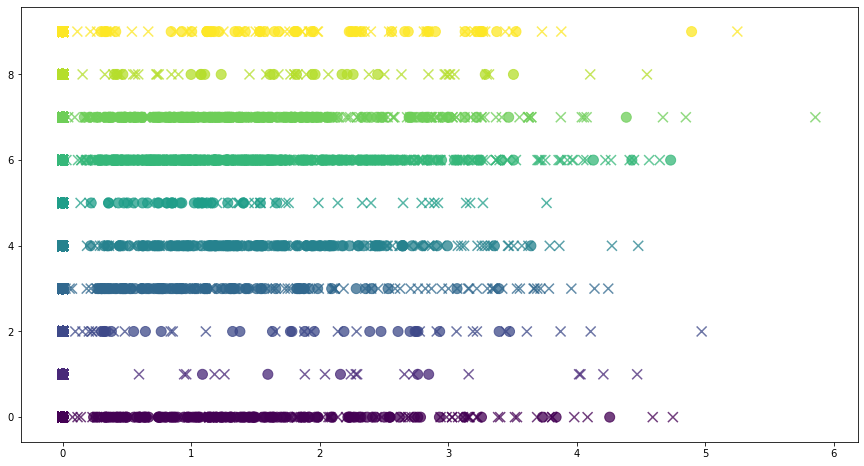

In [15]:
plt.figure(figsize = (15,8))
plt.scatter(df[0],df[target], s = 100, c = df[target], alpha = 0.75)
plt.scatter(df[1], df[target], s = 100, c = df[target], alpha = 0.75, marker = 'x')
plt.show()

No good separation here, unfortunately.

# General Preprocessing <a id = "general">

# Dimensionality Reduction <a id = "dimensionalityReduction">

Transpose:

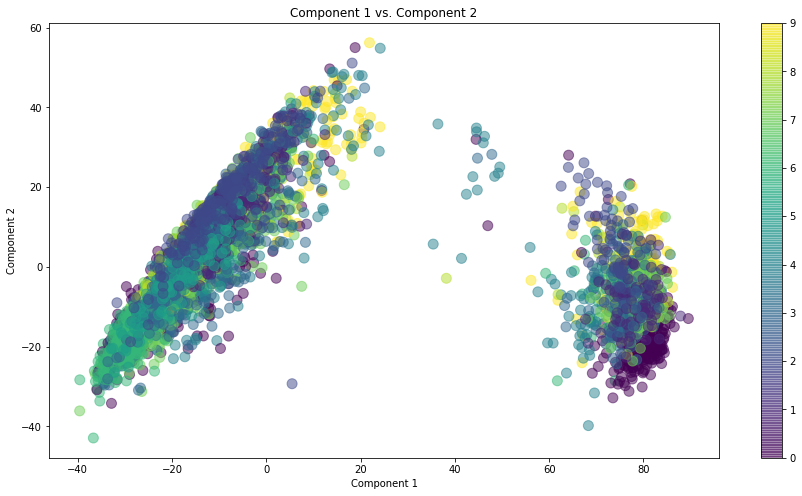

In [16]:
# PCAs
pca = PCA(n_components = 2)
x_pca = pca.fit(df[cols]).transform(df[cols])
plt.figure(figsize = (15,8))
plt.scatter(x_pca[:,0],x_pca[:,1], s = 100, c = df[target], alpha = 0.5, marker = "o",)

plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.title("Component 1 vs. Component 2")
plt.colorbar()
plt.show()

# Now x_pca is a two-dimensional list of the two axes along the data with the most variance

What this tells me here is that yes, there was a way to split up the data, but it doesn't split it up by tumor as I hoped. An issue here may be that the tumors were all selected as "representative" samples, so it would make sense that all 10 tumors were similar to each other in terms of their feature dispersion.

At this point, I looked back to the paper and noticed that in the researchers study that this data was used for, they considered both this dataset and one other one, that represented a different type of tumor. So their ultimate goal was to try and see if there was a different between both of those types. THAT is indeed a supervised learning problem, which (a) would have been much easier for me :) and (b) would have allowed for some more neat analysis based on the PCAs. 

Note that there is no point to performing clustering here, despite how linearly separable it seems.

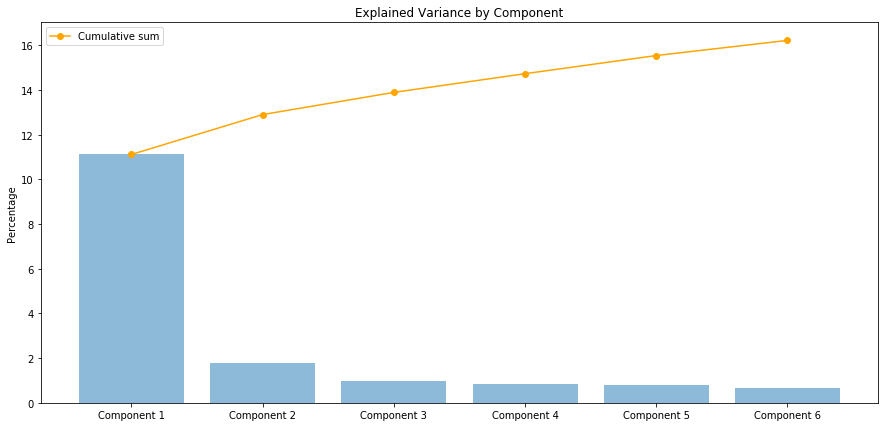

In [17]:
numComponents = 6
pca = PCA(n_components = numComponents).fit(df)

plt.figure(figsize=(15,7))
objects = ["Component " + str(i+1) for i in range(numComponents)]
y_pos = np.arange(len(objects))
performance = pca.explained_variance_ratio_ * 100
cumsum = np.cumsum(performance)

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.title("Explained Variance by Component")
plt.ylabel("Percentage")
plt.plot(y_pos,cumsum, linestyle='-', marker='o', c = "orange", label="Cumulative sum")
plt.legend(loc="best")
plt.show()

Now lets take a look at the coefficients of this largest principal component (component 1).

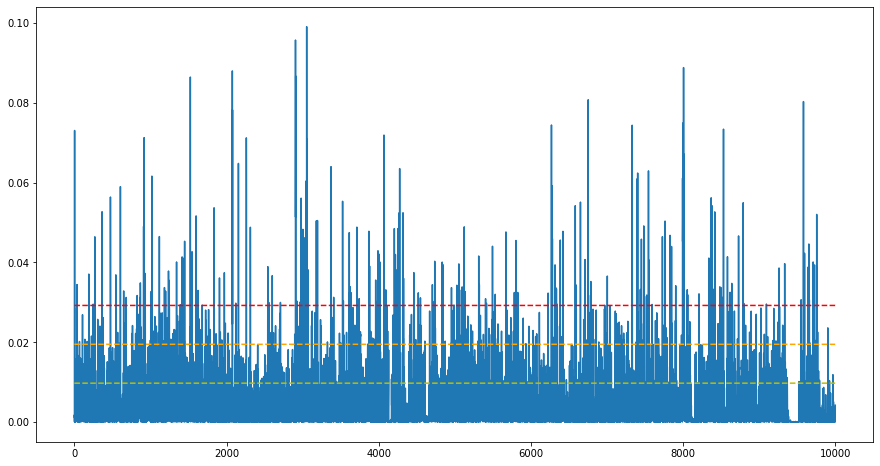

In [18]:
coeffs = pca.components_[0]
std = np.std(coeffs)
plt.figure(figsize=(15,8))
plt.plot(np.abs(coeffs))
plt.plot(std*np.ones(len(coeffs)), linestyle = "--",c = 'y')
plt.plot(2*std*np.ones(len(coeffs)), linestyle = "--", c = 'orange')
plt.plot(3*std*np.ones(len(coeffs)), linestyle = "--",  c = 'r')

plt.show()

As you can see, a fair number of genes lie outside of 99.7% of all the genes involved in the principal components analysis. Let's cut those out and see which genes they represent.

In [19]:
cutoff = 3 * std
gene_outliers = []
for i in range(len(coeffs)):
    if coeffs[i] > cutoff:
        gene_outliers.append(genes[i])
print(gene_outliers)

["'A2M'", "'ACSL1'", "'ACY3'", "'ADAM28'", "'ADORA3'", "'AIF1'", "'ALOX5AP'", "'AOAH'", "'APBB1IP'", "'APOC1'", "'APOC2'", "'APOE'", "'ARHGAP4'", "'ARHGDIB'", "'ARPC1B'", "'ATF3'", "'AXL'", "'B2M'", "'B3GNT5'", "'B4GALT1'", "'BCL2A1'", "'BIN1'", "'C10orf54'", "'C1QA'", "'C1QB'", "'C1QC'", "'C1orf162'", "'C3'", "'C3AR1'", "'C5AR1'", "'CAPG'", "'CCL3'", "'CCL3L1'", "'CCL3L3'", "'CCL4'", "'CCL4L1'", "'CCL4L2'", "'CD14'", "'CD300A'", "'CD37'", "'CD4'", "'CD53'", "'CD68'", "'CD69'", "'CD74'", "'CD83'", "'CD86'", "'CD99'", "'CDKN1A'", "'CH25H'", "'CLEC7A'", "'CLIC1'", "'CNPY3'", "'CORO1A'", "'COTL1'", "'CPVL'", "'CREG1'", "'CSF1R'", "'CSF2RA'", "'CSF3R'", "'CTSB'", "'CTSC'", "'CTSH'", "'CTSS'", "'CX3CR1'", "'CXCL16'", "'CXCR4'", "'CYBA'", "'CYBB'", "'CYFIP1'", "'DHRS3'", "'DOCK8'", "'DUSP1'", "'DUSP2'", "'EGR3'", "'ELF1'", "'ELL2'", "'EPB41L2'", "'ETS2'", "'FCER1G'", "'FCGR1A'", "'FCGR1B'", "'FCGR2A'", "'FCGR3A'", "'FCGRT'", "'FGD2'", "'FKBP5'", "'FOLR2'", "'FOSB'", "'FPR1'", "'FTH1'", "'FTL

In [20]:
print("The number of gene outliers are:", len(gene_outliers))
print("Coming out of a dataset of " + str(df_allcols.shape[0]) + " total genes, this represents \
    " + str(len(gene_outliers) / df_allcols.shape[0]) + "% of the total genes sampled")

The number of gene outliers are: 142
Coming out of a dataset of 10000 total genes, this represents     0.0142% of the total genes sampled


Now that we have the genes with the most variance in our sample, let's look at the genes with the least variance in our sample.

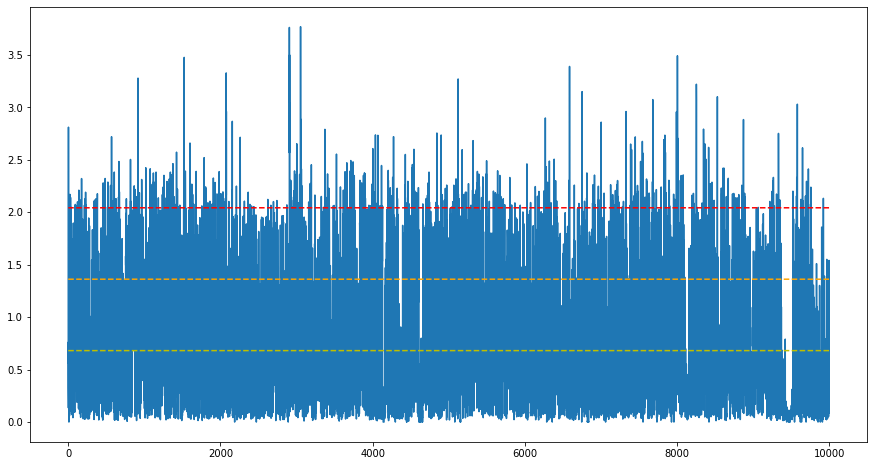

In [21]:
deviations = [np.std(df[col]) for col in cols]
means = [np.mean(df[col]) for col in cols]
plt.figure(figsize=(15,8))
plt.plot(deviations)
std = np.std(deviations )
plt.plot(std*np.ones(len(coeffs)), linestyle = "--",c = 'y')
plt.plot(2*std*np.ones(len(coeffs)), linestyle = "--", c = 'orange')
plt.plot(3*std*np.ones(len(coeffs)), linestyle = "--",  c = 'r')
plt.show()

In [22]:
print("Mean of deviations:", np.mean(deviations))
print("Stdev of deviations:", np.std(deviations))
print("Median of deviations:", np.median(deviations))
print("1% quantile of deviations:", np.quantile(deviations, 0.1))


non_pca_outliers = []
stable_genes = []
dev = np.std(deviations)
m = np.mean(means)
devm = np.std(means)
for i in range(len(deviations)):
    if deviations[i] > 3*dev and np.abs(means[i] - m) < devm:
        non_pca_outliers.append(genes[i])
    if deviations[i] < 1/2 * dev and np.abs(means[i] - m) < 1.0 / 2 * devm:
        stable_genes.append(genes[i])
print(non_pca_outliers)
print(len(non_pca_outliers))
print(len(stable_genes))

Mean of deviations: 0.8407048402147129
Stdev of deviations: 0.6806762180076773
Median of deviations: 0.7070903872686995
1% quantile of deviations: 0.07734498786533146
["'A2M'", "'ABHD14A'", "'ACTL6A'", "'ACTR6'", "'ADORA3'", "'AIF1'", "'ALOX5AP'", "'APOC1'", "'ARHGDIB'", "'ARMCX2'", "'ARMCX6'", "'ATF3'", "'BLVRA'", "'BZW2'", "'C10orf54'", "'C1QA'", "'C1QB'", "'C1QC'", "'C3'", "'C3AR1'", "'CCL3L1'", "'CCL3L3'", "'CCL4'", "'CCL4L1'", "'CCL4L2'", "'CCNB1IP1'", "'CCNG1'", "'CD14'", "'CD53'", "'CD68'", "'CD83'", "'CD99'", "'CDKN1A'", "'CH25H'", "'CORO1A'", "'CREG1'", "'CRYL1'", "'CSF1R'", "'CX3CR1'", "'CXCL16'", "'CXCR4'", "'CYBA'", "'DBNDD2'", "'EFNA1'", "'EMC2'", "'EXOSC5'", "'EZR'", "'FCER1G'", "'FCGR1A'", "'FCGR2A'", "'FCGR3A'", "'FIBIN'", "'FOLR2'", "'FPR1'", "'GMPR2'", "'GPR17'", "'GPR183'", "'GPR34'", "'GSN'", "'HIST2H2BE'", "'HLA-DMA'", "'HLA-DMB'", "'HLA-DPA1'", "'HLA-DRB1'", "'HLA-DRB5'", "'HLA-E'", "'HNRNPA1P10'", "'HRSP12'", "'IER3'", "'IFI30'", "'IL1B'", "'IL8'", "'ITGB2'", "'K

In [23]:
print(stable_genes)

["'AKR1D1'", "'ARNTL2'", "'C14orf105'", "'C18orf61'", "'CD209'", "'CD300LG'", "'CLDN16'", "'CPA4'", "'CYP2B6'", "'DGKE'", "'DKFZP434L187'", "'DSC3'", "'DSG2'", "'DSG3'", "'DUXA'", "'EIF5AL1'", "'EMX2OS'", "'FAM92A1P2'", "'FLJ35282'", "'FLJ46361'", "'FZD2'", "'GBP6'", "'HYDIN2'", "'IFLTD1'", "'LIN28A'", "'LINC00598'"]


In [24]:
intersection = set(non_pca_outliers).intersection(gene_outliers)
intersection_stable = set(stable_genes).intersection(gene_outliers)

print("Number of genes that are both regular variance outliers and in the pca outliers:", len(intersection))
print("Number of genes that are both considered stable and in the pca outliers:", len(intersection_stable))

Number of genes that are both regular variance outliers and in the pca outliers: 54
Number of genes that are both considered stable and in the pca outliers: 0


What does the above mean? Well, if we hadn't done PCAs and strictly looked at the variance of various genes, we would have found 77 total genes that may be outliers. But with PCAs, we identified 142. 

The benefit of PCAs is that we saw a  much clearer distribution of data over those components, so we have much higher confidence that removing that component will bring the data closer together. The benefit of regular feature variance is that we can much easier discount and remove those genes from our dataset, by simply dropping those columns. So it's a mixed bag. The best of both worlds is to remove the 54 genes in both categories.

**So what does this leave us with?**
First, we need to return to the question we're trying to answer. The question that the researchers in their paper tried to answer is, what is the difference between IDH-A (this type) and IDH-O tumors? So what we *do* want is to find differences between IDH-A and IDH-O genes. What we ideally *do not* want is to find differences within IDH-A genes. Having said that, here are the conclusions I have come away with.
1. In the above, we analyzed the data to find the genes that caused the most variance within our dataset. The PCA_outliers and the regular standard-deviation outliers both returned a couple hundred genes that we should look out for, and their intersection consisted of 54 genes that really caused variance in our data. What this means is that these 54 genes are the least consistent among the tumor samples, which means they're probably the least meaningful genes to predict the existence of one of these types of tumors. If we want to turn this into something usable, I suggest that we remove those genes from our dataset when comparing IDH-A and IDH-O, as they may create false appearances of variance in the data.


2. At the end here, we also included a list of stable genes. Those were the genes who had less than half the typical standard deviation between the different tumors AND had a mean that was within half a standard deviation of the general mean of the genes. The first condition here means we get the genes that are the most consistent among all the tumors. The second condition makes sure that there is some expression in the dataset. Hypothetically, we could have a gene that had 0 standard deviation because it was 0 for all the samples. Those genes really aren't that meaningful, whereas the ones we have now pulled out as "stable" are somewhat meaningful. How is this useful? Well, when we (or anyone) starts comparing IDH-A and IDH-O genes, I suggest we start by looking at the differences in these genes specifically between the datasets. Chances are that most of them aren't that different from one type of tumor to the other. But there may be one single gene in this set that does have a large variance between IDH-A and IDH-O, and that could be the key to tumor classification.


3. When we performed PCAs, we saw that the first two components pretty much split the data into two separate groups. The 10 tumors were equally distributed throughout the groups, and this may well be a result of genetics and location sampling, but when comparing IDH-A and IDH-O we may also want to compare the left and right groups separately.

This is where the real meat of my analysis comes to an end. The rest of this notebook is just me playing around with some models and error calculation methods, but as you'll see nothing substantiative comes from it. Additionally, when you think back to what we are actually doing here, we shouldn't *want* to find a model to separate our tumor classification. They ultimately all belong to the same class. To be honest, I should probably have deleted the rest of these cells. But I figured they added some more cool graphs and statistics and more numbers never hurt anyone. If this was a real presentation to a possibly less-informed audience (like an insights presentation), I would definitely exclude it though.

# Choosing Models <a id = "choosing">

In [25]:
model = LogisticRegression()

# Test-Train Split <a id = "test-train">

In [26]:
trainDF, testDF = train_test_split(df, test_size=0.25)
print(trainDF.shape)
print(testDF.shape)

(4755, 10001)
(1586, 10001)


# Validation to Determine Hyperparameters <a id = "validation">

In [27]:
trainVDF, validationDF = train_test_split(trainDF, test_size=0.25)

Once again I split the dataframe (although this time I just split the training dataframe) into validation training (trainVDF) and validation testing (validationDF) dataframes.

In [28]:
modelV = LogisticRegression().fit(trainVDF[cols],trainVDF[target]) # the validation model
rmse = math.sqrt(sklearn.metrics.mean_squared_error(y_true = validationDF[target], y_pred = modelV.predict(validationDF[cols])))
print("Initial rmse: " + str(rmse)) # the RMSE of the default model (C = 1)

minC, maxC = 0.0001, 1000000 # starting and stopping bounds for C
C = minC

RMSEs = [] # create a list of the RMSE of the model at each C

while C <= maxC:
    modelV = LogisticRegression(C = C).fit(trainVDF[cols],trainVDF[target]) # the validation model
    rmse = math.sqrt(sklearn.metrics.mean_squared_error(y_true = validationDF[target], y_pred = modelV.predict(validationDF[cols])))
    RMSEs.append(rmse)
    C *= 10 # Since we really only care about the order of maginitude of the C that minimizes RMSE, not its definite value,
            # I am only cycling through the powers of C

m = min(RMSEs) 
print('Minimum RMSE: ' + str(m))
Cminimized = minC * (10**RMSEs.index(m)) # finds the C that corresponds to the minimized RMSE
print("This minimum occurs at C = " + str(Cminimized))


/Users/Eric/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Initial rmse: 0.9753048303966929


/Users/Eric/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/Eric/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_m

Minimum RMSE: 0.9530615534384738
This minimum occurs at C = 100.0


In this block I tested a bunch of different values for C (which is just 1/lambda), the hyperparameter in logistic regression models. I trained each model on the trainVDF dataframe (the dataframe to train the hyperparameter), and calculated the RMSE based on the validation dataframe. I then chose the minimum of all the RMSE's and found it's C value. 

As you can see, we get a lot of "lack of convergence" errors. I'm not really surprised at all since this dataset is just not linearly separable. This was done really for the sake of doing it rather than hoping for some cool results.

In [29]:
C = Cminimized

Now C stores the C that minimizes RMSE on the training dataframe.

# Fitting <a id = "fitting">

In [30]:
model = LogisticRegression(C = C)
model.fit(trainDF[cols],trainDF[target])
rmse = math.sqrt(sklearn.metrics.mean_squared_error(y_true = testDF[target], y_pred = model.predict(testDF[cols])))
print("RMSE of all features: " + str(rmse))

/Users/Eric/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


RMSE of all features: 1.015640611239026


The above is fairly straightforward, simply fitting a logistic regression model at the proper C value and displaying its RMSE. 

# Decision Trees and Random Forests <a id = "trees">

For the decision trees and random forests, since I have so many features, plotting each pair of features individually would take up a huge amount of time and space, and is mostly useless or repeated data. Instead, I will plot the first two principal components from the unengineered features and from the engineered features. However, I will still compute the RMSEs of the models on entire engineered dataframe.

In [31]:
# Redoing the PCAs for the engineered dataset
pca = PCA(n_components = 2)
xE_pca = pca.fit(df[cols]).transform(df[cols]) # xE_pca is now a two-dimensional list containing the two axes of
                                               # highest variance with the engineered features

Standard PCA code. Note that, like before, I am running PCAs on the entire dataset rather than just the training set, which I can do since I'm not using the PCAs for prediction yet. 

In [32]:
# Note: I made my own edits to the function to make it work for my own data
def visualize_classifier(model, X, y, ax=None, cmap='rainbow'):
    ax = ax or plt.gca()
    
    # Plot the training points
    try:
        ax.scatter(X.iloc[:,0],X.iloc[:,1], c=y, s=30,
                   clim=(y.min(), y.max()), zorder=3)
    except:
        ax.scatter(X[:,0],X[:,1], c=y, s=30,
                    clim=(y.min(), y.max()), zorder=3)

    ax.axis('tight')
    ax.axis('on')
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # fit the estimator
    model.fit(X, y)
    xx, yy = np.meshgrid(np.linspace(*xlim, num=200),
                         np.linspace(*ylim, num=200))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    # Create a color plot with the results
    n_classes = len(np.unique(y))
    contours = ax.contourf(xx, yy, Z, alpha=0.3,
                           levels=np.arange(n_classes + 1) - 0.5,
                           zorder=1)

    ax.set(xlim=xlim, ylim=ylim) 
    names = list(X)
    ax.set_xlabel(names[0])
    ax.set_ylabel(names[1])

/Users/Eric/opt/anaconda3/lib/python3.7/site-packages/matplotlib/text.py:1150: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:
/Users/Eric/opt/anaconda3/lib/python3.7/site-packages/matplotlib/text.py:1150: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:
/Users/Eric/opt/anaconda3/lib/python3.7/site-packages/matplotlib/text.py:1150: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:
/Users/Eric/opt/anaconda3/lib/python3.7/site-packages/matplotlib/text.py:1150: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


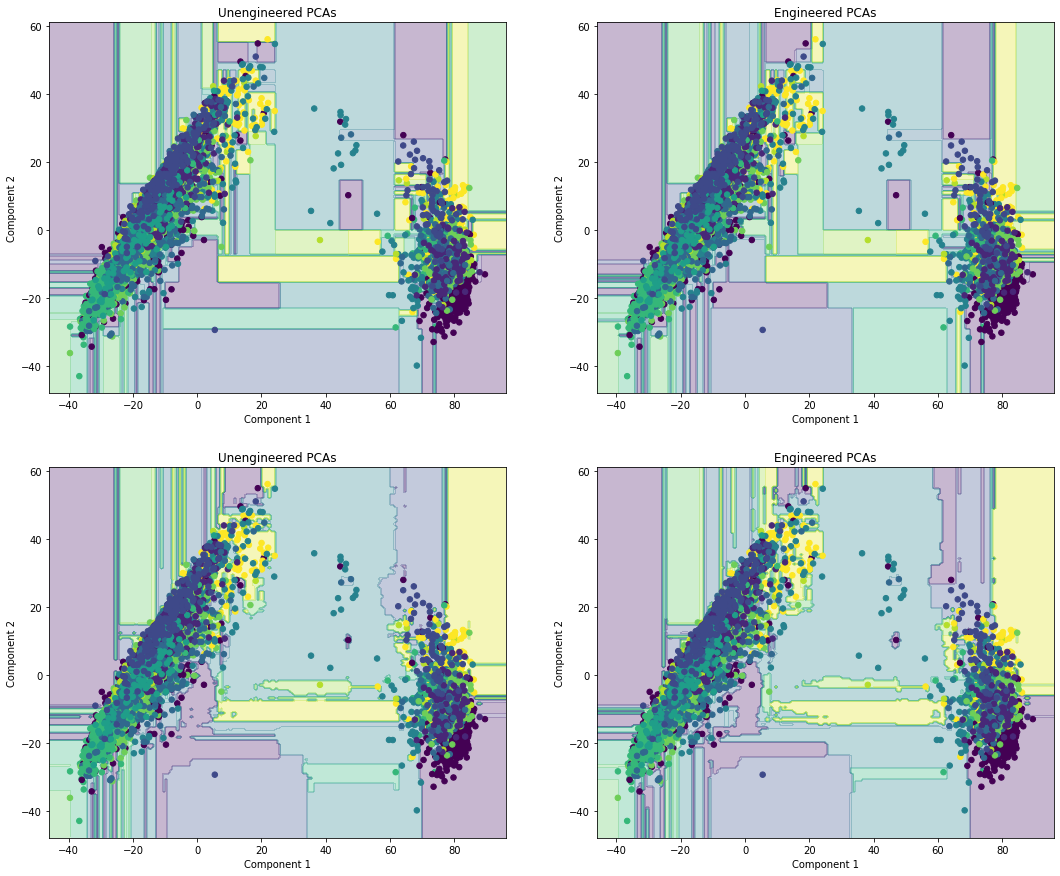

In [33]:
f, axes = plt.subplots(nrows = 2, ncols=2, figsize = (18,15)) 
tree = DecisionTreeClassifier()
tree.fit(x_pca,df[target]) # I am using the whole df[target] column (rather than the trainDF[target] columns)
                           # since the pca's were determined from the whole dataframe
treeE = DecisionTreeClassifier()
treeE.fit(xE_pca,df[target]) 


# Unengineered Tree
visualize_classifier(tree, x_pca, df[target], ax = axes[0][0])
axes[0][0].set_title("Unengineered PCAs")
axes[0][0].set_xlabel("Component 1")
axes[0][0].set_ylabel("Component 2")

# Engineered Tree
visualize_classifier(treeE, xE_pca, df[target], ax = axes[0][1])
axes[0][1].set_title("Engineered PCAs")
axes[0][1].set_xlabel("Component 1")
axes[0][1].set_ylabel("Component 2")

# Unengineered Forest
bag = BaggingClassifier(tree, n_estimators=100, max_samples=0.8)
bag.fit(x_pca, df[target])
visualize_classifier(bag, x_pca, df[target], ax = axes[1][0])
axes[1][0].set_title("Unengineered PCAs")
axes[1][0].set_xlabel("Component 1")
axes[1][0].set_ylabel("Component 2")

# Engineered Forest
bagE = BaggingClassifier(treeE, n_estimators=100, max_samples=0.8)
bagE.fit(xE_pca, df[target])
visualize_classifier(bag, xE_pca, df[target], ax = axes[1][1])
axes[1][1].set_title("Engineered PCAs")
axes[1][1].set_xlabel("Component 1")
axes[1][1].set_ylabel("Component 2")


plt.show()


Above, I plotted engineered and unengineered PCAs and their decision trees. I ended up not including any engineered features (since there were too many features to begin with), so the engineered graphs are the same as the unengineered graphs. Clearly this is a terrible fit, there's not much to see here.

In [34]:
pca = PCA(n_components = 2)
xE_pca = pca.fit(trainDF[cols]).transform(trainDF[cols]) # only want to remove the outliers in the training data
xE_pca_NEW = []
correctness = []
for i in range(len(xE_pca[:,0])): 
    elem = xE_pca[i,0]
    if elem < 20:
        correctness.append(True)
    else:
        correctness.append(False)
trainDF = trainDF[correctness] # horizontally slice data

In [35]:
# Computing RMSEs of both models on entire training dataset (i.e. with outliers)
tree = DecisionTreeClassifier()
tree.fit(trainDF[cols],trainDF[target])
# Bag is the random forest classifier
bag = BaggingClassifier(tree, n_estimators=100, max_samples=0.8)
                                        # These parameters were what the author of the above cited notebook
                                        # used in his function. I took them, learned what each meant, and
                                        # intentionally am choosing to reuse those same values. 
bag.fit(trainDF[cols],trainDF[target])
treePred = tree.predict(testDF[cols]) # now is an array containing the predictions of the tree on the test data
bagPred = bag.predict(testDF[cols]) # array of predictions of the random forest on the test data
rmseTree = math.sqrt(sklearn.metrics.mean_squared_error(y_true = testDF[target], y_pred = treePred))
rmseBag = math.sqrt(sklearn.metrics.mean_squared_error(y_true = testDF[target], y_pred = bagPred))
print("Decision tree RMSE: " + str(rmseTree))
print("Random forest (bag) RMSE: " + str(rmseBag))

Decision tree RMSE: 2.8842748853262203
Random forest (bag) RMSE: 2.0356222344685664


As seen above, I computed the root mean square errors for both the decision tree classifier as well as the random forest (bagging) classifier. These are truly terrible errors.

# Conclusion <a id = "conclusion">

Most of the conclusion can be seen before the model selection section. We didn't really see anything new past that, but it was still cool to try.